# End to end CNN for GTzan music classification EnvCNN


WINDOWED Version

Adapted by AL Koerich

To GTzan 3-fold

11 December 2018

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import soundfile as sf
from numpy import *
import soundfile as sf

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from keras import regularizers

import os, sys
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten
from keras.callbacks import TensorBoard
from keras.utils import np_utils, to_categorical
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
import keras.initializers as init

os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
config = tf.ConfigProto( )
config.gpu_options.allow_growth = True
sess   = tf.Session(config=config)
import keras.backend.tensorflow_backend as tf_bkend
tf_bkend.set_session(sess)

In [ ]:
#controling_Hyper parameters
batch_size = 60
nb_classes = 10
nb_epoch   = 300
frame_size = 110250

In [3]:
X_train = np.load( "/home-2/akoerich/GTzan_Xs_fold2-3_110250_75.npy" )
Y_train = np.load( "/home-2/akoerich/GTzan_Ys_fold2-3_110250_75.npy" )
# t_train = np.load( "t_train_13_220500_50_256_box_id.npy" )
# s_train = np.load( "s_train_13_220500_50_256_box_id.npy" )


X_valid = np.load( "/home-2/akoerich/GTzan_Xs_fold1_110250_75.npy" )
Y_valid = np.load( "/home-2/akoerich/GTzan_Ys_fold1_110250_75.npy" )
# t_valid = np.load( "t_valid_2_220500_50_256_box_id.npy" )
# s_valid = np.load( "s_valid_2_220500_50_256_box_id.npy" )

In [4]:
X_train.min(), X_train.max()

(-1.0, 1.0000000000000004)

In [5]:
X_valid.min(), X_valid.max()

(-1.0, 1.0000000000000004)

In [6]:
# If a validation split is not provided

#from sklearn.model_selection import train_test_split

#X_train, X_valid, Y_train, Y_valid = train_test_split(X_train2, Y_train2, test_size=0.10, stratify=Y_train2, random_state=42)

In [7]:
import gc
#X_train2 = None
#Y_train2 = None
#gc.collect()

In [8]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape
#, t_train.shape, s_train.shape

((16493, 110250, 1), (16493, 10), (8497, 110250, 1), (8497, 10))

In [ ]:
# best so far 0.53160 for 10-fold
# dec 10. comecou dec 9 tarde.


# best so far 0.64008 for 3-fold
# GTzan_3f_fold1-2_110250_75Tue Dec 11 10:26:42 2018


def model_generator_alenet4():
    from keras.layers import Input, Dense
    from keras.layers import AveragePooling1D
    from keras.models import Model
    from keras import initializers
    from keras.callbacks import ModelCheckpoint
    from keras.layers import LeakyReLU    
    
    inp =  Input(shape=(frame_size,1))
    #----------------------
    conv1 = Conv1D(filters=32, kernel_size=128, strides=2)(inp)
    norm1 = BatchNormalization()(conv1)
    act1  = LeakyReLU(alpha=0.1)(norm1)
    drop1 = Dropout(0.10)(act1)
    # 8 -> 4
    pool1 = AveragePooling1D(pool_size=4, strides=4)(drop1)
    #----------------------
    conv2 = Conv1D(filters=16, kernel_size=256, strides=2)(pool1)
    norm2 = BatchNormalization()(conv2)
    act2  = LeakyReLU(alpha=0.1)(norm2)
    drop2b = Dropout(0.10)(act2)
    # 8 -> 4
    pool2 = AveragePooling1D(pool_size=4, strides=4)(drop2b)
    #----------------------
    conv3 = Conv1D(filters=32, kernel_size=64, strides=2 )(pool2)
    norm3 = BatchNormalization()(conv3)
    act3  = LeakyReLU(alpha=0.1)(norm3)
    drop3b = Dropout(0.10)(act3)
    #----------------------
    conv4 = Conv1D(filters=64, kernel_size=32, strides=2 )(drop3b)
    norm4 = BatchNormalization()(conv4)
    act4  = LeakyReLU(alpha=0.1)(norm4)
    drop4b = Dropout(0.10)(act4)
    #----------------------
    conv5 = Conv1D(filters=128, kernel_size=16, strides=2 )(drop4b)
    norm5 = BatchNormalization()(conv5)
    act5  = LeakyReLU(alpha=0.1)(norm5)
    drop5b = Dropout(0.10)(act5)
    
    pool3 = AveragePooling1D(pool_size=2, strides=2)(drop5b)

    flat = Flatten()(pool3)

    #dense1 = Dense(1024, activation='relu')(flat)
    #drop1  = Dropout(0.50)(dense1)
    
    #dense1 = Dense(2048, activation='relu')(flat)
    #drop1  = Dropout(0.50)(dense1)

    dense2 = Dense(1024, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0) )(flat)
    drop2  = Dropout(0.55)(dense2)

    dense2a = Dense(512, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0) )(drop2)
    drop2a  = Dropout(0.55)(dense2a)
    
    dense3a = Dense(256, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0) )(drop2a)
    drop3a  = Dropout(0.50)(dense3a)
    
    dense3 = Dense(nb_classes, activation='softmax')(drop3a)
    model  = Model(inp, dense3)

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
              ,metrics=['accuracy'])
    
    # keras.losses.categorical_crossentropy(y_true, y_pred)
    # keras.losses.kullback_leibler_divergence(y_true, y_pred)
    
    model.summary()
    
    return model

In [ ]:
def model_generator_alenet5():
    from keras.layers import Input, Dense
    from keras.layers import AveragePooling1D
    from keras.models import Model
    from keras import initializers
    from keras.callbacks import ModelCheckpoint
    from keras.layers import LeakyReLU    
    
    inp =  Input(shape=(frame_size,1))
    #----------------------
    conv1 = Conv1D(filters=32, kernel_size=128, strides=2)(inp)
    norm1 = BatchNormalization()(conv1)
    act1  = LeakyReLU(alpha=0.1)(norm1)
    drop1 = Dropout(0.10)(act1)
    # 8 -> 4
    pool1 = AveragePooling1D(pool_size=4, strides=4)(drop1)
    #----------------------
    conv2 = Conv1D(filters=16, kernel_size=256, strides=2)(pool1)
    norm2 = BatchNormalization()(conv2)
    act2  = LeakyReLU(alpha=0.1)(norm2)
    drop2b = Dropout(0.10)(act2)
    # 8 -> 4
    pool2 = AveragePooling1D(pool_size=4, strides=4)(drop2b)
    #----------------------
    conv3 = Conv1D(filters=32, kernel_size=64, strides=2 )(pool2)
    norm3 = BatchNormalization()(conv3)
    act3  = LeakyReLU(alpha=0.1)(norm3)
    drop3b = Dropout(0.10)(act3)
    #----------------------
    conv4 = Conv1D(filters=64, kernel_size=32, strides=2 )(drop3b)
    norm4 = BatchNormalization()(conv4)
    act4  = LeakyReLU(alpha=0.1)(norm4)
    drop4b = Dropout(0.10)(act4)
    #----------------------
    conv5 = Conv1D(filters=128, kernel_size=16, strides=2 )(drop4b)
    norm5 = BatchNormalization()(conv5)
    act5  = LeakyReLU(alpha=0.1)(norm5)
    drop5b = Dropout(0.10)(act5)
    
    #pool3 = AveragePooling1D(pool_size=2, strides=2)(drop5b)

    flat = Flatten()(drop5b)

    #dense1 = Dense(1024, activation='relu')(flat)
    #drop1  = Dropout(0.50)(dense1)
    
    #dense1 = Dense(2048, activation='relu')(flat)
    #drop1  = Dropout(0.50)(dense1)

    dense2 = Dense(1024, kernel_initializer=initializers.glorot_uniform(seed=0) )(flat)
    actd2  = LeakyReLU(alpha=0.1)(dense2)
    drop2  = Dropout(0.6)(actd2)

    dense2a = Dense(512, kernel_initializer=initializers.glorot_uniform(seed=0) )(drop2)
    actd2a  = LeakyReLU(alpha=0.1)(dense2a)
    drop2a  = Dropout(0.5)(actd2a)
    
    #dense3a = Dense(256, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0) )(drop2a)
    #drop3a  = Dropout(0.50)(dense3a)
    
    dense3 = Dense(nb_classes, activation='softmax')(drop2a)
    model  = Model(inp, dense3)

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
              ,metrics=['accuracy'])
    
    # keras.losses.categorical_crossentropy(y_true, y_pred)
    # keras.losses.kullback_leibler_divergence(y_true, y_pred)
    
    model.summary()
    
    return model

In [9]:
import scipy.io as sio
contents_mat=sio.loadmat('filters_32_512.mat')
gammatone = contents_mat['filters_32_512']
CNN_1st_layer_filters = np.transpose(gammatone)
CNN_1st_layer_filters_rev=np.zeros((512,32))
for i in reversed(range(32)):
    CNN_1st_layer_filters_rev[:,31-i]=CNN_1st_layer_filters[:,i]
    



In [10]:
def model_generator_alenet4c():
    from keras.layers import Input, Dense
    from keras.layers import AveragePooling1D
    from keras.models import Model
    from keras import initializers
    from keras.callbacks import ModelCheckpoint
    from keras.layers import LeakyReLU    
    
    inp =  Input(shape=(frame_size,1))
    #----------------------
    conv1 = Conv1D(filters=32, kernel_size=512, activation='relu', kernel_initializer=init.Constant(CNN_1st_layer_filters_rev), trainable=True)(inp)
    norm1 = BatchNormalization()(conv1)
    pool1 = AveragePooling1D(pool_size=8, strides=8)(norm1)
    #----------------------
    conv2 = Conv1D(filters=16, kernel_size=256, strides=2)(pool1)
    norm2 = BatchNormalization()(conv2)
    act2  = LeakyReLU(alpha=0.1)(norm2)
    drop2b = Dropout(0.10)(act2)
    pool2 = AveragePooling1D(pool_size=8, strides=8)(drop2b)
    #----------------------
    conv3 = Conv1D(filters=32, kernel_size=64, strides=2 )(pool2)
    norm3 = BatchNormalization()(conv3)
    act3  = LeakyReLU(alpha=0.1)(norm3)
    drop3b = Dropout(0.10)(act3)
    #----------------------
    conv4 = Conv1D(filters=64, kernel_size=32, strides=2 )(drop3b)
    norm4 = BatchNormalization()(conv4)
    act4  = LeakyReLU(alpha=0.1)(norm4)
    drop4b = Dropout(0.10)(act4)
    #----------------------
    conv5 = Conv1D(filters=128, kernel_size=16, strides=2 )(drop4b)
    norm5 = BatchNormalization()(conv5)
    act5  = LeakyReLU(alpha=0.1)(norm5)
    drop5b = Dropout(0.10)(act5)
    
    pool3 = MaxPool1D(pool_size=2, strides=2)(drop5b)

    flat = Flatten()(pool3)

    dense2 = Dense(512, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0) )(flat)
    drop2  = Dropout(0.55)(dense2)
    
    dense3 = Dense(nb_classes, activation='softmax')(drop2)
    model  = Model(inp, dense3)

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
              ,metrics=['accuracy'])
    
    model.summary()
    
    return model

In [11]:
fold = 2-3
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import time
from livelossplot import PlotLossesKeras
hist = []


now = time.strftime("%c")
tbcallback = TensorBoard(log_dir='./tmp/GTzan_3f_fold2-3_110250_75_suffle_gammatone_512dense_'+now, histogram_freq=0, write_graph=True, write_images=True )

#for train_index, test_index in kf.split(X):
#generating the model 
model = model_generator_alenet4c()

#checkpoints
str0="weights/"
str1="weights_GTzan_3f_fold2-3_110250_75_shuffle_alenet4c_gammatone_512dense" 
str2=".best.hdf5" 
filepath=str0+str1+str2 
print(filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') 
callbacks_list = [checkpoint, tbcallback, PlotLossesKeras()]




Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110250, 1)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 109739, 32)        16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109739, 32)        128       
_________________________________________________________________
average_pooling1d_1 (Average (None, 13717, 32)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6731, 16)          131088    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6731, 16)       

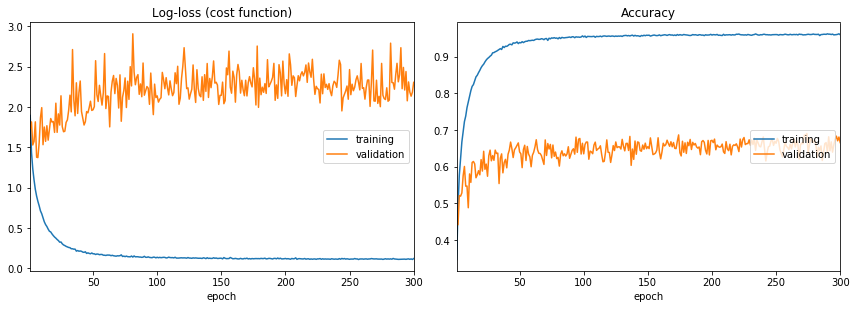

Log-loss (cost function):
training   (min:    0.110, max:    1.897, cur:    0.122)
validation (min:    1.374, max:    2.909, cur:    2.307)

Accuracy:
training   (min:    0.347, max:    0.962, cur:    0.960)
validation (min:    0.442, max:    0.691, cur:    0.666)


In [12]:
#fitting the model 
hist.append(model.fit(X_train, Y_train,
                      batch_size = batch_size, 
                      epochs = nb_epoch,
                      verbose = 1,
                      shuffle = True,
                      callbacks = callbacks_list,
                      validation_data = (X_valid, Y_valid)
                     ))

In [13]:
filepath

'weights/weights_GTzan_3f_fold2-3_110250_75_shuffle_alenet4c_gammatone_512dense.best.hdf5'

https://www.music-ir.org/nema_out/mirex2017/results/act/latin_report/accperfold.html

MIREX 2017:



Summary Results    [top]
Algorithm
Classification Accuracy
Normalised Classification Accuracy
LPNKK1
0.7586
0.7571
PLNPH1
0.6619
0.6573
XLJ1
0.6148
0.6079
LPNKK3
0.7347
0.7324
LPNKK2
0.6511
0.6458





Fold
LPNKK1
LPNKK2
LPNKK3
PLNPH1
XLJ1
1
0.7186
0.6041
0.6860
0.5795
0.5453
0
0.7627
0.6426
0.7444
0.6772
0.5998
2
0.8055
0.7194
0.7872
0.7518
0.7183


/Users/akoerich/Dropbox/Mendeley/pdf/Aytar, Vondrick, Torralba - 2016.pdf

/Users/akoerich/HOME/ETS/Etudiants/Sajjad Abdoli/DGA1032/DGA1032-Dissertation_abdoli.pdf